## Importing the libraries

In [181]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## Importing the data 

In [309]:
raw_data_directory = "..\\data\\raw\\"
!dir $raw_data_directory

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\DataDriven.org\TimeSeries_Energy_Forecasting\Energy_Forecasting\data\raw

10/14/2018  03:38 PM    <DIR>          .
10/14/2018  03:38 PM    <DIR>          ..
10/13/2018  03:18 PM                 0 .gitkeep
10/13/2018  03:18 PM         6,551,136 cold_start_test.csv
10/13/2018  03:18 PM        29,833,323 consumption_train.csv
10/14/2018  03:38 PM        33,193,146 energy_df.pkl
10/13/2018  03:19 PM            82,949 meta.csv
10/14/2018  03:38 PM           118,993 meta_df.pkl
10/13/2018  03:19 PM           384,277 submission_format.csv
10/13/2018  03:19 PM         4,767,322 test_df.pkl
10/13/2018  03:19 PM        20,771,586 train_df.pkl
               9 File(s)     95,702,732 bytes
               2 Dir(s)  1,926,683,344,896 bytes free


In [310]:
# Importing the data
energy = pd.read_csv(raw_data_directory+ "consumption_train.csv", index_col=0)
meta = pd.read_csv(raw_data_directory + "meta.csv")

## Extracting the dimensions of each dataset

In [311]:
# Printing the column names and dimension of both data sets
print("The columns are =>", energy.columns)
print("The timeseries dataset dimensions are =>", energy.shape)
print("The metadata dataset dimensions are =>", meta.shape)

The columns are => Index(['series_id', 'timestamp', 'consumption', 'temperature'], dtype='object')
The timeseries dataset dimensions are => (509376, 4)
The metadata dataset dimensions are => (1383, 10)


In [312]:
# Preview of the datasets
print(energy.info())
print()
print(meta.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509376 entries, 0 to 509375
Data columns (total 4 columns):
series_id      509376 non-null int64
timestamp      509376 non-null object
consumption    509376 non-null float64
temperature    280687 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 19.4+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 10 columns):
series_id               1383 non-null int64
surface                 1383 non-null object
base_temperature        1383 non-null object
monday_is_day_off       1383 non-null bool
tuesday_is_day_off      1383 non-null bool
wednesday_is_day_off    1383 non-null bool
thursday_is_day_off     1383 non-null bool
friday_is_day_off       1383 non-null bool
saturday_is_day_off     1383 non-null bool
sunday_is_day_off       1383 non-null bool
dtypes: bool(7), int64(1), object(2)
memory usage: 41.9+ KB
None


In [313]:
# Number of unique time series in the energy df
len(energy["series_id"].unique())

758

In [314]:
# Number of unique time series in the meta df
len(meta["series_id"].unique())

1383

## Counting the missing values

In [121]:
# Counting missing values
print(energy.isnull().sum())
print()
print(meta.isnull().sum())

series_id           0
timestamp           0
consumption         0
temperature    228689
dtype: int64

series_id               0
surface                 0
base_temperature        0
monday_is_day_off       0
tuesday_is_day_off      0
wednesday_is_day_off    0
thursday_is_day_off     0
friday_is_day_off       0
saturday_is_day_off     0
sunday_is_day_off       0
dtype: int64


## Exploratory Data Analysis
### Correlation between energy consumption and temperature

,series_id,consumption,temperature
series_id,1.000000,0.013681,-0.116543
consumption,0.013681,1.000000,0.099456
temperature,-0.116543,0.099456,1.000000


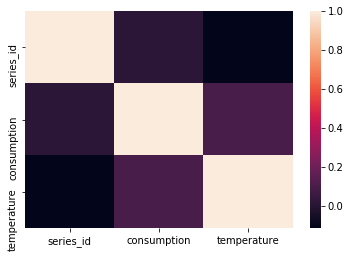

In [122]:
# Getting correlational heatmap, focussing on the potential relationship between consumption and temperature
corr = energy.corr()
sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
corr

In [123]:
new_col = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
cols = ["monday_is_day_off", "tuesday_is_day_off", "wednesday_is_day_off", "thursday_is_day_off",
       "friday_is_day_off", "saturday_is_day_off", "sunday_is_day_off"]

def add_empty_col(df, col):
    df[col] = 0

# Changing the on/off bit of the week-day: 1-> is on that day, 0-> is off that day    
def convert_bool_binary(df, col, new_col):
    for i in range(len(df)):
        if df[col][i] == False:
            df[new_col][i] = 1
        else:
            df[new_col][i] = 0
            
#Looking for potential grouping patterns in days of the week ON/OFF
print("Different levels of the surface feature:",meta.surface.unique())
print("Different levels of the base_temperature feature:", meta.base_temperature.unique())

# Adding new empty columns (see above [new_col]) to fill them in with binary variable
# on whether it is a day OFF/ON
for i in new_col:
    add_empty_col(meta, i)
    


# This is highly inefficient!!! See if we can vectorized the above function 
convert_bool_binary(meta, "monday_is_day_off", "monday")
convert_bool_binary(meta, "tuesday_is_day_off", "tuesday")
convert_bool_binary(meta, "wednesday_is_day_off", "wednesday")
convert_bool_binary(meta, "thursday_is_day_off", "thursday")
convert_bool_binary(meta, "friday_is_day_off", "friday")
convert_bool_binary(meta, "saturday_is_day_off", "saturday")
convert_bool_binary(meta, "sunday_is_day_off", "sunday")

# Creating a new descriptive feature where a vector is created representing if power is shut down (i.e., 1) 
# or turn on (i.e., 0). This will help grouping similar buildings together 
meta["weekly"] = meta.monday.map(str) + meta.tuesday.map(str) + meta.wednesday.map(str) + meta.thursday.map(str) + meta.friday.map(str) + meta.saturday.map(str) + meta.sunday.map(str)


Different levels of the surface feature: ['x-large' 'x-small' 'medium' 'large' 'xx-large' 'xx-small' 'small']
Different levels of the base_temperature feature: ['low' 'high']


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [124]:
# Check how the updated meta df looks like
meta.head()

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,monday,tuesday,wednesday,thursday,friday,saturday,sunday,weekly
0,100003,x-large,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100
1,100004,x-large,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100
2,100006,x-small,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100
3,100008,x-small,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100
4,100010,x-small,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100


In [126]:
display(meta["weekly"].unique())

array(['1111100', '1111111', '1111110', '1111000', '1100000', '1111101',
       '0000000'], dtype=object)

## EDA 2 - Looking At The Count Of Each Weekly Group

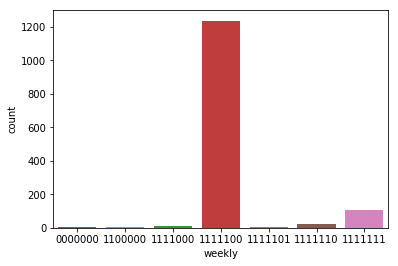

In [127]:
# Number of buildings in each weekly group
sns.countplot(x="weekly", data=meta)

In [128]:
meta["weekly"].value_counts()

1111100    1236
1111111     104
1111110      21
1111000      10
1111101       5
0000000       4
1100000       3
Name: weekly, dtype: int64

Looking at the last table, we get some more insights on power utilization. We can observe a higher number
buildings (e.g., 1236) having the power turned on. Now, it would be interesting to look if these patterns correlate with the spikes observed in the timeseries. If so, we can think of creating 7 different models, each locked to a specific power usage.  
    
 N.B.: The notation on the x-axis is quite confusing. Here is the legend associated with it:
    -  1111111 => Mon-Sun always on            :  104
    -  1111110 => Mon-Tues-Wed-Thu-Fri-Sat on  :   21
    -  1111101 => Mon-Tues-Wed-Thu-Fri-Sun on  :    5
    -  1111100 => Mon-Tues-Wed-Thu-Fri on      : 1236
    -  1111000 => Mon-Tues-Wed-Thu on          :   10
    -  1100000 => Mon-Tues on                  :    3
    -  0000000 => Mon-Sun Always off           :    4

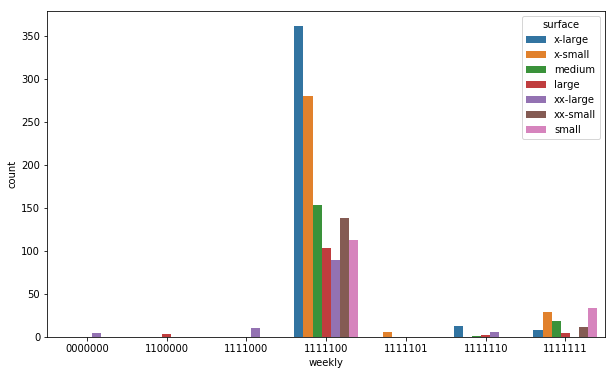

In [129]:
# Number of buildings for each weekly group deparated by their surface
plt.figure(figsize=(10,6))
sns.countplot(x="weekly", data=meta, hue="surface")

In [307]:
len(energy["series_id"].unique())

758

In [131]:
# Transform the timestamp to a datetime type
energy['timestamp'] = pd.to_datetime(energy['timestamp'])
# Add the day of the week to the dataframe
energy['timestamp_weekday'] = energy['timestamp'].dt.day_name()

In [132]:
energy.head()

,series_id,timestamp,consumption,temperature,timestamp_weekday
0,103088,2014-12-24 00:00:00,101842.233424,NaN,Wednesday
1,103088,2014-12-24 01:00:00,105878.048906,NaN,Wednesday
2,103088,2014-12-24 02:00:00,91619.105008,NaN,Wednesday
3,103088,2014-12-24 03:00:00,94473.706203,NaN,Wednesday
4,103088,2014-12-24 04:00:00,96976.755526,NaN,Wednesday


In [133]:
energy = pd.merge(energy, meta[["series_id", "surface", "base_temperature", "weekly"]], on="series_id")
energy.head()

,series_id,timestamp,consumption,temperature,timestamp_weekday,surface,base_temperature,weekly
0,103088,2014-12-24 00:00:00,101842.233424,NaN,Wednesday,x-small,low,1111100
1,103088,2014-12-24 01:00:00,105878.048906,NaN,Wednesday,x-small,low,1111100
2,103088,2014-12-24 02:00:00,91619.105008,NaN,Wednesday,x-small,low,1111100
3,103088,2014-12-24 03:00:00,94473.706203,NaN,Wednesday,x-small,low,1111100
4,103088,2014-12-24 04:00:00,96976.755526,NaN,Wednesday,x-small,low,1111100


In [308]:
len(energy["series_id"].unique())

758

## Plotting the relationship between the energy consumption and the size of the building

In the following section, I'll be looking at the relationship between the surface, the weekly use, and the electricity consumption. First, we will look at:
    - the relationship between consumption and the size of the building (i.e., surface)
    - the relationship between the consumption and the ON/OFF time during the week
    - the relationship between the consumption and the ON/OFF time grouped by the surface

### Consumption and surface

In [134]:
# Plotting the relationship between the energy consumption and the size of the building

order = ["xx-small", "x-small", "small", "medium", "large", "x-large", "xx-large"]

def plot_boxplot_barplot(x, y, data, order, ci, hue):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    sns.boxplot(x=x, y=y, data=data, order=order)

    plt.subplot(1,2,2)
    sns.barplot(x=x, y=y, ci=ci, data=data, order=order, hue=hue)


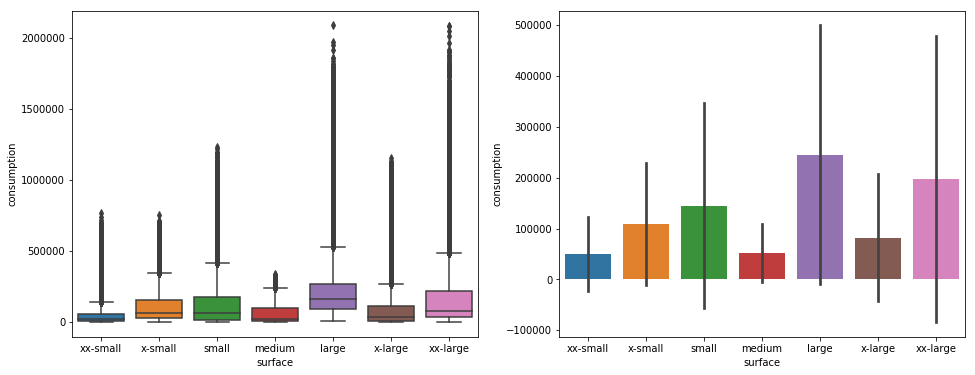

In [135]:
plot_boxplot_barplot("surface", "consumption", data=energy, order=order, ci="sd", hue=None)

### Consumption and Day of the Week

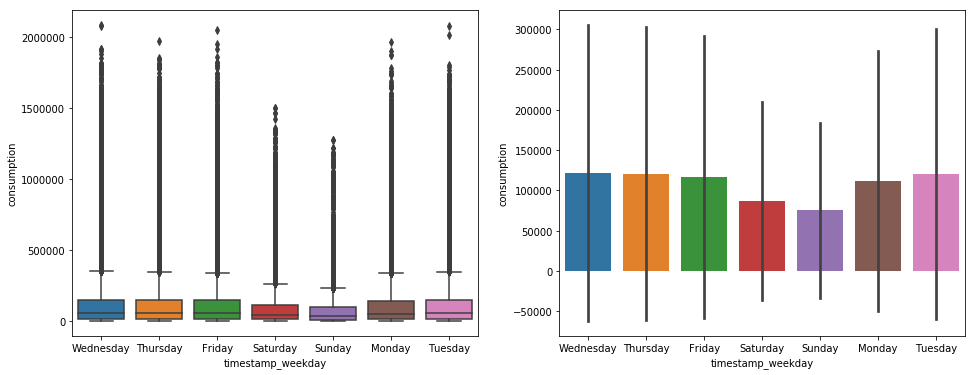

In [136]:
plot_boxplot_barplot(x="timestamp_weekday", y="consumption", data=energy, ci="sd", order=None, hue=None)

### Consumption versus ON/OFF time 

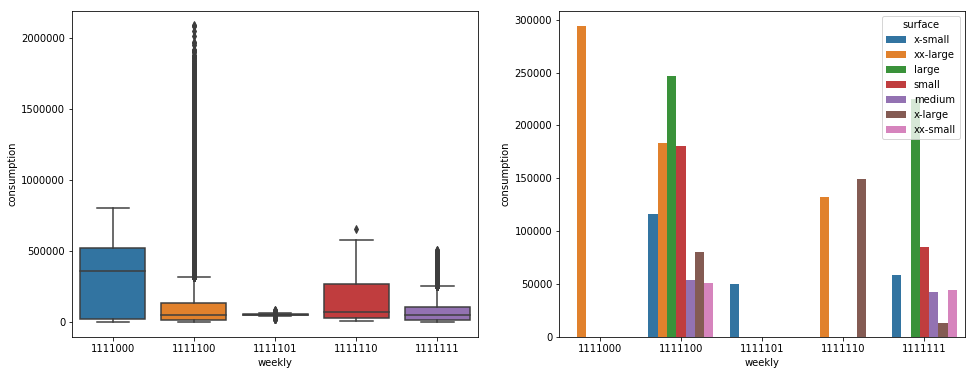

In [138]:
plot_boxplot_barplot(x="weekly", y="consumption", data=energy, order=None, ci=None, hue="surface")

### Consumption versus ON/OFF time grouped by building size

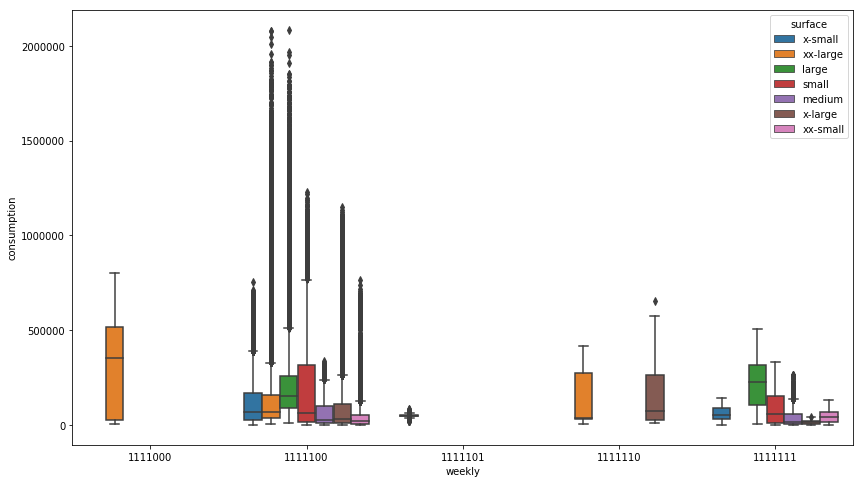

In [19]:
plt.figure(figsize=(14,8))
sns.boxplot(x="weekly", y="consumption", data=energy, hue="surface")

From the previous EDA, we can say that:
- large buildings have a greater energy consumption in average. 
- XX-large buildings with energy consumption on Mon/Tue/Wed/Th have the highest energy consumption.
- a large amount of variation is probably explained by the ON/OFF pattern and the number of buildings associated with this pattern

## Consumption Distributions

In [21]:
def plot_distplot(x, y, data, order, ci, hue):  
    plt.figure(figsize=(16,18))
    building_type_list = data[x].unique()
    num_building_type = len(building_type_list)    
    for i in range(num_building_type):
        plt.subplot(round((num_building_type+1)/2),2,i+1)
        sns.distplot(data[data[x]==building_type_list[i]][y], axlabel = building_type_list[i])

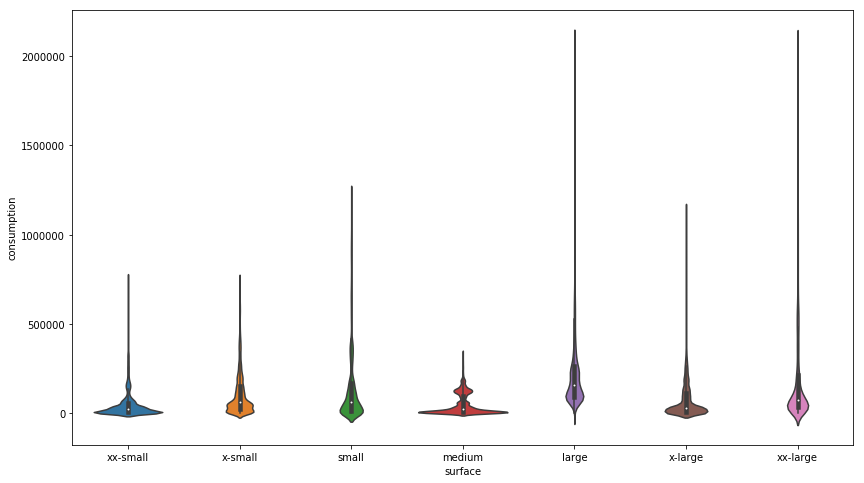

In [22]:
plt.figure(figsize=(14,8))
sns.violinplot("surface", "consumption", data=energy, order=order)

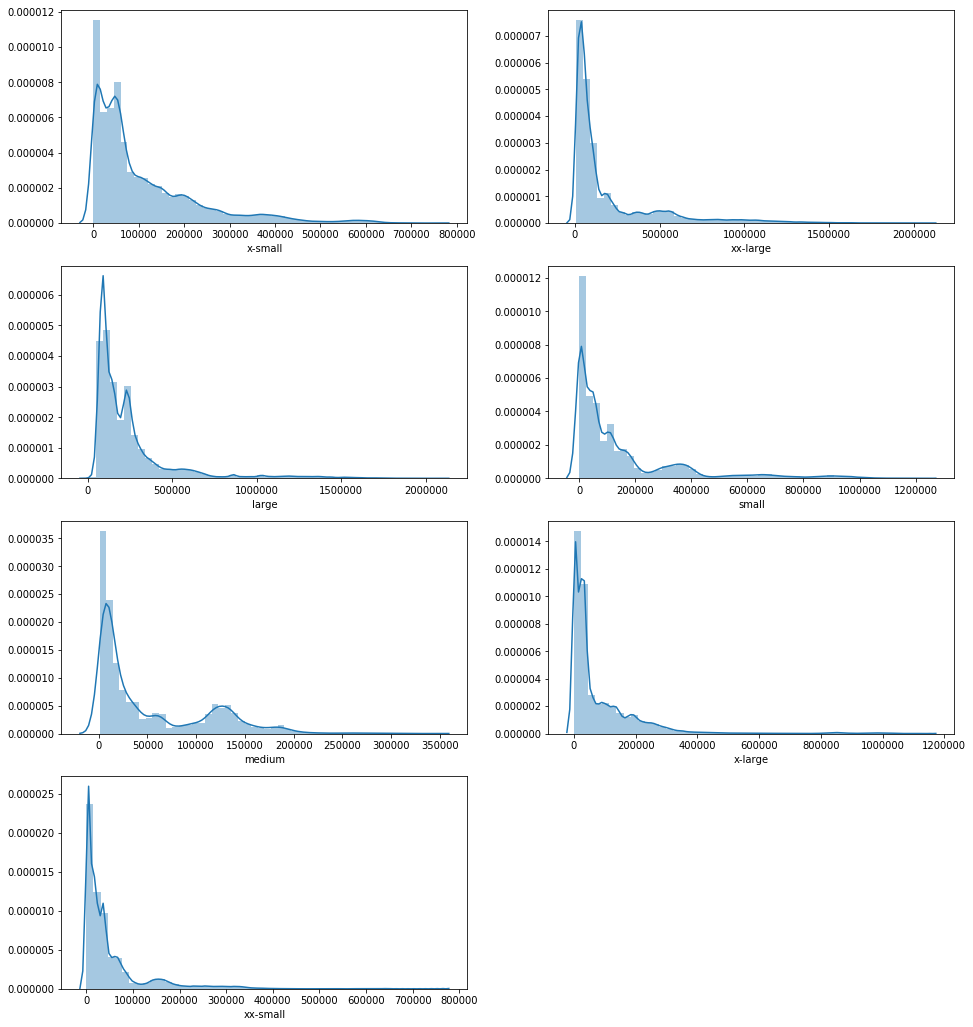

In [23]:
plot_distplot("surface", "consumption", data=energy, order=order, ci="sd", hue=None)

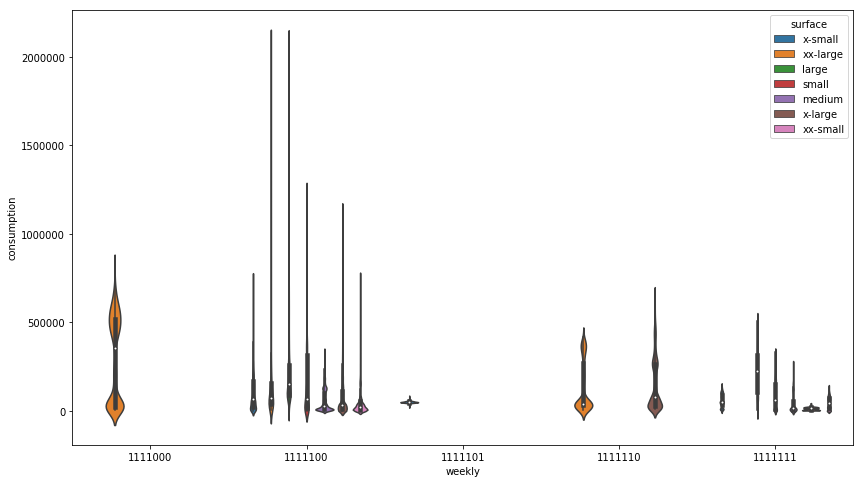

In [32]:
plt.figure(figsize=(14,8))
sns.violinplot(x="weekly", y="consumption", data=energy, order=None, ci=None, hue="surface")

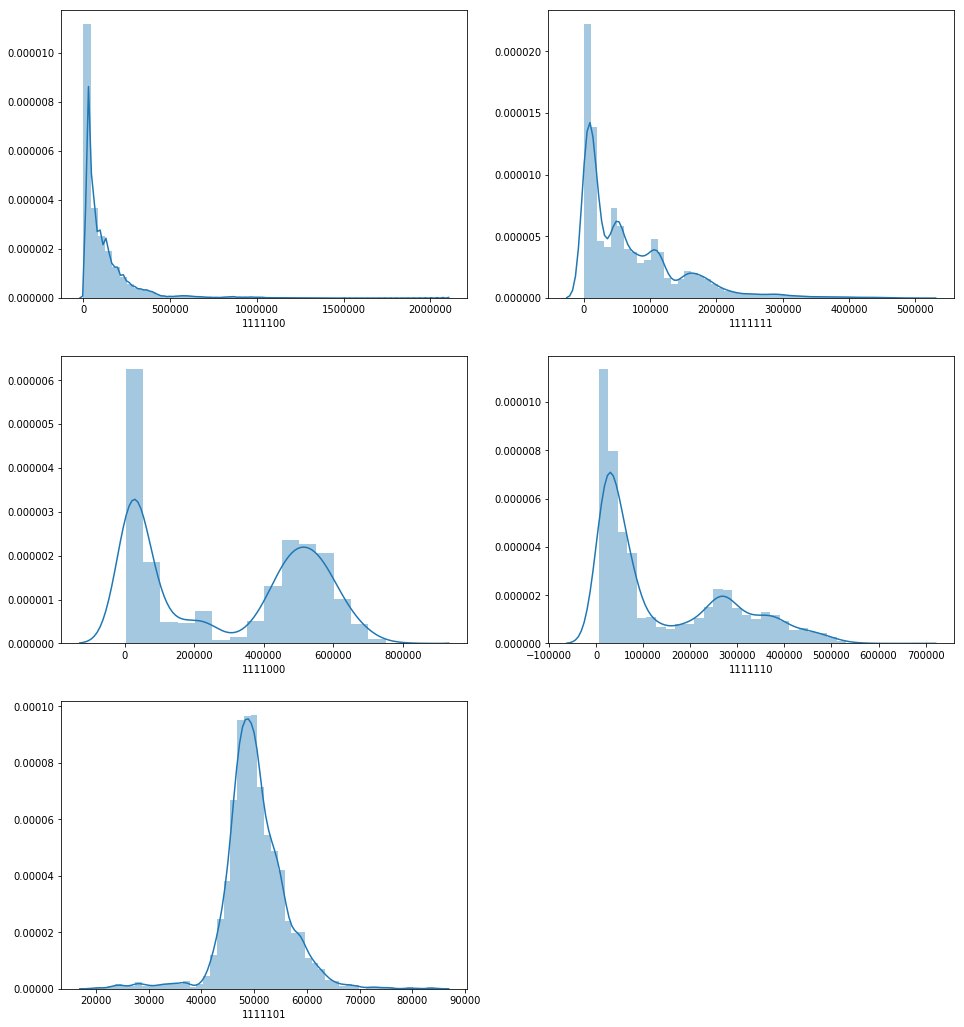

In [33]:
plot_distplot(x="weekly", y="consumption", data=energy, order=None, ci=None, hue="surface")

## Time Series Pattern According To The ON/OFF State

Below is an overview of the energy consumption for 5 xx-large buildings with energy on the ON-state Mon/Tues/Wed/Th/Sat. We can see a clear pattern related to the ON/OFF state which suggest that buildings with different patterns may have a different tiie series model created specifically for them.

In [243]:
# Subsetting a dataframe with the Mon/Tues/Wed/Th/Sat state
df1 = energy[(energy.weekly == "1111110")][energy.surface == "xx-large"]
print(df1.shape)
df1.series_id.unique()

(3360, 8)


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([100979, 103457, 101443, 101792, 103373], dtype=int64)

In [244]:
df1[df1.series_id==101443].head()

,series_id,timestamp,consumption,temperature,timestamp_weekday,surface,base_temperature,weekly
486528,101443,2017-06-29 00:00:00,33627.891241,11.0,Thursday,xx-large,low,1111110
486529,101443,2017-06-29 01:00:00,33627.891241,10.0,Thursday,xx-large,low,1111110
486530,101443,2017-06-29 02:00:00,33627.891241,10.0,Thursday,xx-large,low,1111110
486531,101443,2017-06-29 03:00:00,33627.891241,10.0,Thursday,xx-large,low,1111110
486532,101443,2017-06-29 04:00:00,34787.473697,10.0,Thursday,xx-large,low,1111110


(array([736608., 736620., 736632., 736644., 736656.]),
 <a list of 5 Text xticklabel objects>)

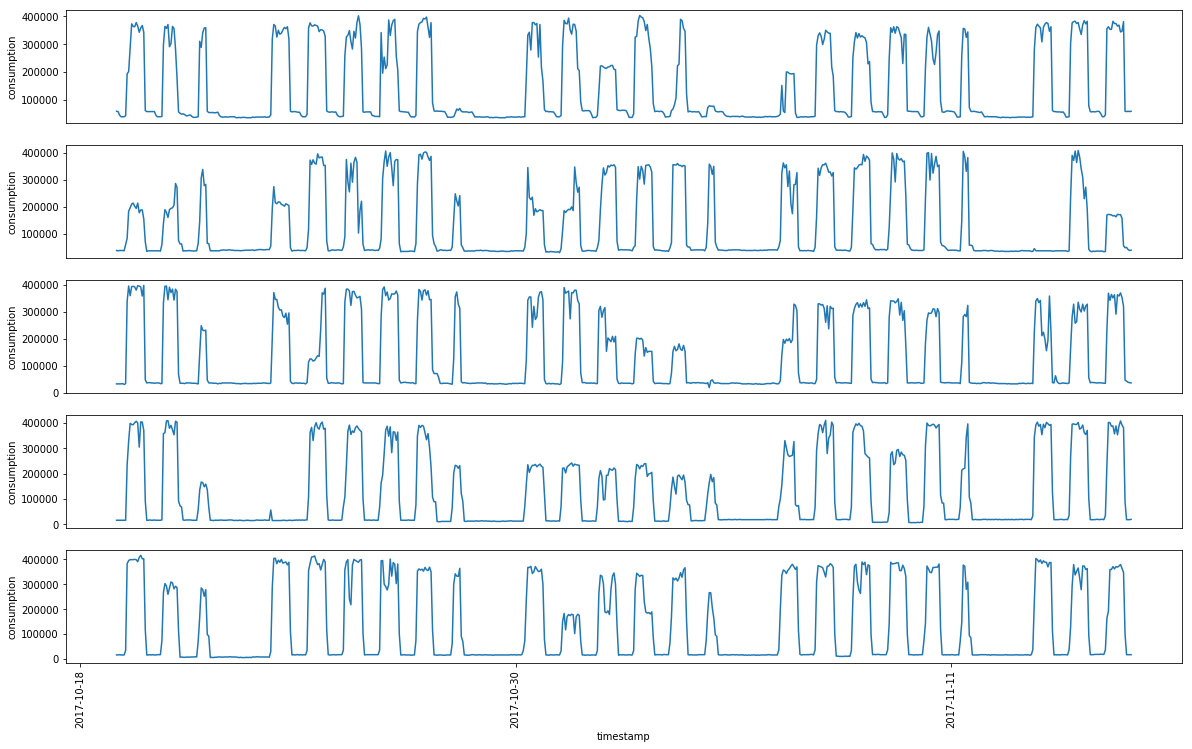

In [144]:
import matplotlib.ticker as ticker
    
plt.figure(figsize=(20,12))
    
plt.subplot(5,1,1)
ax = sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==100979])
ax.set_xlabel('')
ax.set(xticks=[])

plt.subplot(5,1,2)
bx = sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==103457])
bx.set_xlabel('')
bx.set(xticks=[])

plt.subplot(5,1,3)
cx = sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==101443])
cx.set_xlabel('')
cx.set(xticks=[])

plt.subplot(5,1,4)
dx = sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==101792])
dx.set_xlabel('')
dx.set(xticks=[])

plt.subplot(5,1,5)
ex=sns.lineplot(x="timestamp", y="consumption", data=df1[df1.series_id==103373])
ex.xaxis.set_major_locator(ticker.MultipleLocator(12))
plt.xticks(rotation=90)

In [235]:
import random
weekly_cat = meta["weekly"].unique()

def plot_random_series(surface_type, weekly_type, num_series_to_plot = 1):
    # Subsetting a dataframe 
    df_subset = energy[(energy.weekly == weekly_type)][energy.surface == surface_type]
    plt.figure(figsize=(20,15))
    title_str = "Building Type [" + surface_type + "] [" + weekly_type + "]"
    for k in range(1, num_series_to_plot+1):
        series_list = df_subset.series_id.unique()
        if (len(series_list) > 0):
            rand_series_id = random.choice(series_list)
            plt.subplot(num_series_to_plot,1,k)
            ax = sns.lineplot(x="timestamp", y="consumption", data=df_subset[df_subset.series_id==rand_series_id])
            ax.set_title(title_str+ " " + "Series: " + str(rand_series_id))
            ax.set_xlabel('')
            ax.set(xticks=[])
            ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
            plt.subplots_adjust(hspace = .5)

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


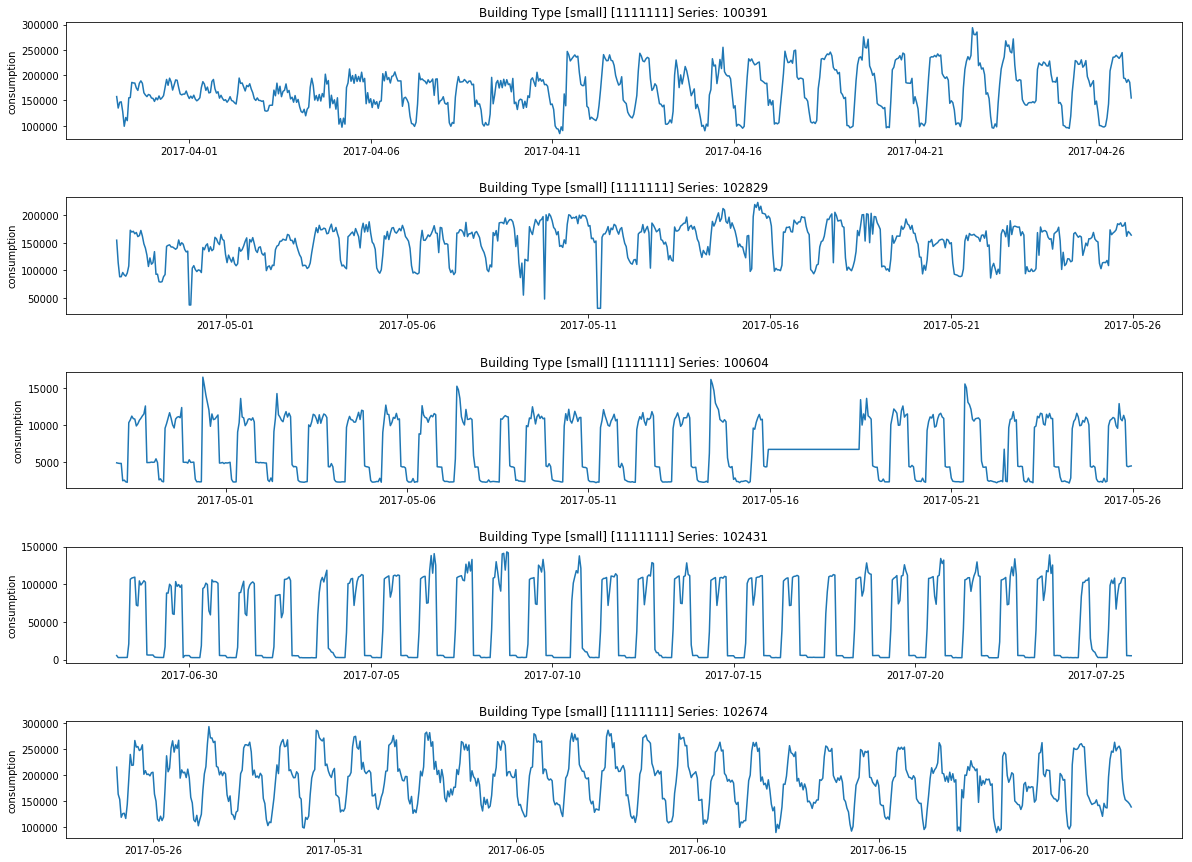

In [236]:
plot_random_series (surface_type= 'small', weekly_type = '1111111', num_series_to_plot = 5)

In [291]:
def plot_acf_random_series(surface_type, weekly_type, num_series_to_plot = 1):
    # Subsetting a dataframe 
    df_subset = energy[(energy.weekly == weekly_type)][energy.surface == surface_type]
    title_str = "Building Type [" + surface_type + "] [" + weekly_type + "]"
    for k in range(1, num_series_to_plot+1):
        series_list = df_subset.series_id.unique()
        if (len(series_list) > 0):
            fig = plt.figure(figsize=(8,3))
            fig.suptitle(title_str)
            rand_series_id = random.choice(series_list)
            pd.plotting.autocorrelation_plot(df_subset[df_subset.series_id==rand_series_id]["consumption"])

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


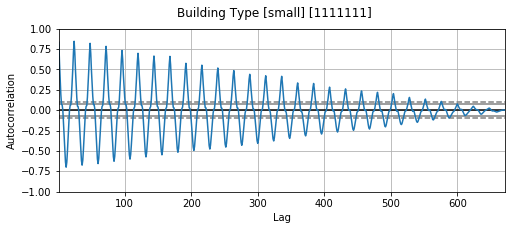

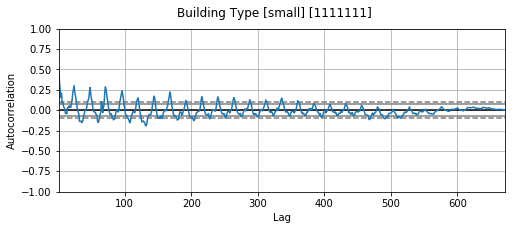

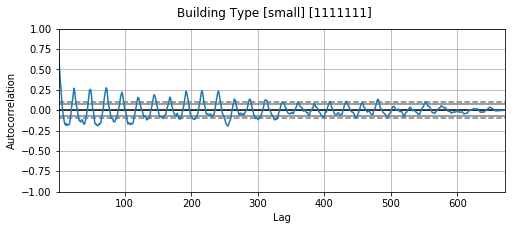

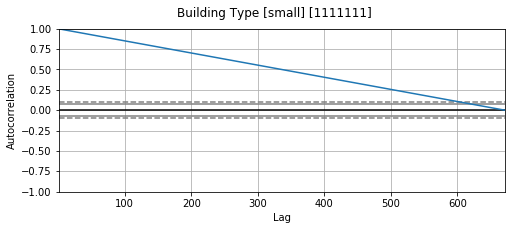

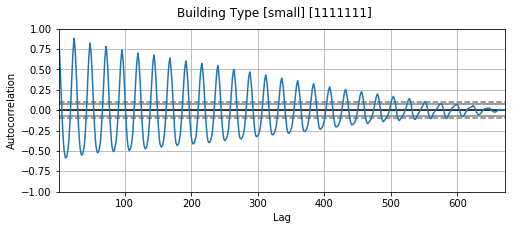

In [292]:
plot_acf_random_series(surface_type= 'small', weekly_type = '1111111', num_series_to_plot = 5)

In [294]:
meta.head()

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,monday,tuesday,wednesday,thursday,friday,saturday,sunday,weekly
0,100003,x-large,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100
1,100004,x-large,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100
2,100006,x-small,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100
3,100008,x-small,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100
4,100010,x-small,low,False,False,False,False,False,True,True,1,1,1,1,1,0,0,1111100


In [300]:
# Save the meta and energy df to pickle
interim_data_directory = "..\\data\\interim\\"
meta.to_pickle(interim_data_directory + 'meta_df.pkl')
energy.to_pickle(interim_data_directory + 'energy_df.pkl')

In [301]:
!dir $interim_data_directory

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\DataDriven.org\TimeSeries_Energy_Forecasting\Energy_Forecasting\data\interim

10/14/2018  03:40 PM    <DIR>          .
10/14/2018  03:40 PM    <DIR>          ..
10/13/2018  03:18 PM                 0 .gitkeep
10/14/2018  03:41 PM        33,193,146 energy_df.pkl
10/14/2018  03:41 PM           118,993 meta_df.pkl
               3 File(s)     33,312,139 bytes
               2 Dir(s)  1,926,683,709,440 bytes free
